### Classification models
##### Without Departure Delay Column and balanced

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

import xgboost as xgb

##### Load the SQL db for later comparison

In [2]:
import sqlite3
conn=sqlite3.connect("models.db")
cur=conn.cursor()

In [3]:
#Loading the dataset
df=pd.read_csv('depdelay20enc.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df=df.drop(['Unnamed: 0','DepDelay'],axis=1)
df = df.sample(frac =.02).reset_index().drop(['index'], axis=1)
df.head()

,CRSElapsedTime,Distance,ArrDelay,DepTime_sin,DepTime_cos,ArrTime_sin,ArrTime_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,origin_freq,dest_freq,carrier
0,0.379379,-0.244648,0,-0.081069,-0.996709,-0.515786,-8.567175e-01,-1.000000,-1.836970e-16,-0.781831,0.623490,0.004273,0.055796,0.059441
1,0.297798,-0.518349,0,-0.939094,0.343660,-0.707107,7.071068e-01,0.866025,-5.000000e-01,0.000000,1.000000,0.030147,0.000988,0.072968
2,0.603103,-0.015291,1,-0.932639,-0.360811,-0.999877,1.570732e-02,0.866025,-5.000000e-01,0.433884,-0.900969,0.012285,0.014367,0.026351
3,0.073073,-0.584098,1,-0.333807,-0.942641,-0.549023,-8.358074e-01,-0.866025,-5.000000e-01,0.000000,1.000000,0.001805,0.016548,0.195616
4,0.423423,0.022936,0,-0.737867,-0.674947,-1.000000,-1.836970e-16,0.000000,1.000000e+00,0.433884,-0.900969,0.006695,0.024669,0.195616


##### Split Train and Test  and set ArrDelay as target column

In [4]:
X,y = df.loc[:, df.columns != 'ArrDelay'],df.loc[:, df.columns == 'ArrDelay']

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42, stratify=y)

##### The target classes are imbalanced, it can be balanced undersampling the majority class (1)

In [8]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)


# Separate majority and minority classes
df_majority = X[X.ArrDelay==1]
df_minority = X[X.ArrDelay==0]

print('majority-1',len(df_majority),'minority-0',len(df_minority))

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
downsampled['ArrDelay'].value_counts()

majority-1 3803 minority-0 1981


0    1981
1    1981
Name: ArrDelay, dtype: int64

In [9]:
y_train = downsampled.ArrDelay
X_train = downsampled.drop('ArrDelay', axis=1)

##### Support Vector Classification

In [18]:
clf = svm.SVC(kernel='linear', random_state=42, gamma='auto')
scores = cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % scores)

Accuracy Score: 0.5758


In [19]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [20]:
cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

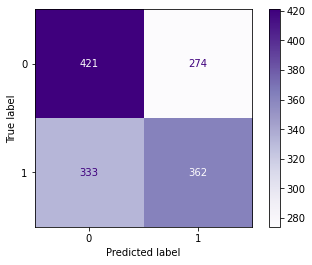

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 

In [22]:
#Specificity = TN / (TN + FP)
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.6058
Accuracy: 0.5633
Precision: 0.5692
Recall or Sensitivity: 0.5209
F1 Score: 0.544


In [23]:
model='sv2bal'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### KNN K-Nearest Neighbors

In [24]:
knn = KNeighborsClassifier(n_neighbors=32)
score=cross_val_score(knn, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5475


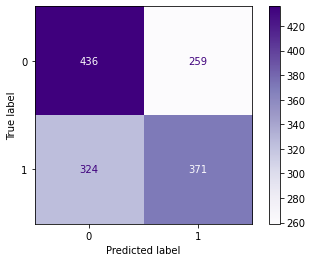

In [25]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 


In [26]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.6273
Accuracy: 0.5806
Precision: 0.5889
Recall or Sensitivity: 0.5338
F1 Score: 0.56


In [27]:
model='knn2bal'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### logistic regression

In [28]:
logreg = LogisticRegression(solver='liblinear')
score=cross_val_score(logreg, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5840


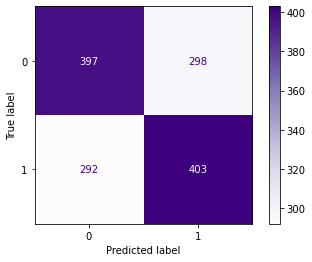

In [29]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 

In [30]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.5712
Accuracy: 0.5755
Precision: 0.5749
Recall or Sensitivity: 0.5799
F1 Score: 0.5774


In [31]:
model='lg2bal'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### Decision Tree

In [32]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=42)
scores=cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % scores)

Accuracy Score: 0.5665


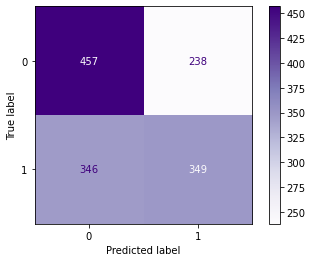

In [33]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 

In [34]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.6576
Accuracy: 0.5799
Precision: 0.5945
Recall or Sensitivity: 0.5022
F1 Score: 0.5445


In [35]:
model='dt2bal'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### neural network MLPClassifier

In [36]:
mlp = MLPClassifier(hidden_layer_sizes=(20, 10, 5), max_iter=50, activation = 'relu',solver='adam',random_state=42)
score=cross_val_score(mlp, X_train, y_train, cv=StratifiedKFold(n_splits=10), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5880


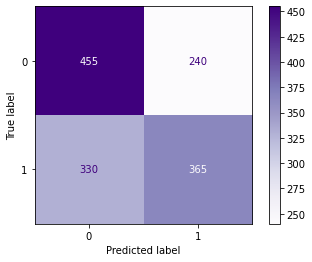

In [37]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 

In [38]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.6547
Accuracy: 0.5899
Precision: 0.6033
Recall or Sensitivity: 0.5252
F1 Score: 0.5615


In [39]:
model='nn2bal'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### Gaussian Naive Bayes

In [40]:
clf = GaussianNB()
score=cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5845


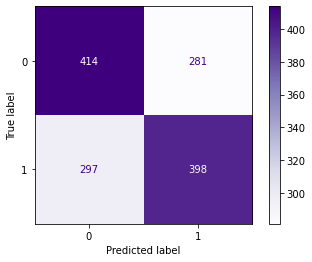

In [41]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 

In [44]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.5957
Accuracy: 0.5842
Precision: 0.5862
Recall or Sensitivity: 0.5727
F1 Score: 0.5793


In [45]:
model='nb2bal'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()



##### Ada Boost Classifier

In [46]:
ada = AdaBoostClassifier(n_estimators=12, random_state=42,algorithm='SAMME')
score=cross_val_score(ada, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5710


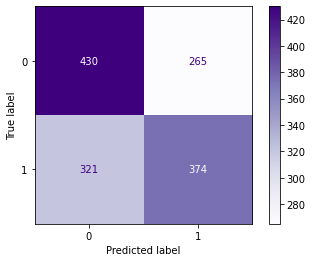

In [47]:
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples') 

In [48]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.6187
Accuracy: 0.5784
Precision: 0.5853
Recall or Sensitivity: 0.5381
F1 Score: 0.5607


In [49]:
model='ada2bal'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### Gaussian Process Classifier

In [50]:
gpc = GaussianProcessClassifier(kernel=1*RBF(1.0))
score=cross_val_score(gpc, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5938


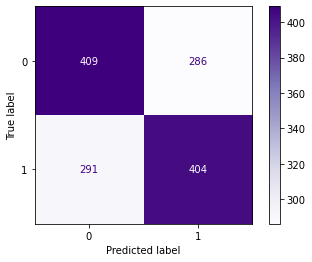

In [51]:
gpc.fit(X_train, y_train)
y_pred = gpc.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples') 

In [52]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.5885
Accuracy: 0.5849
Precision: 0.5855
Recall or Sensitivity: 0.5813
F1 Score: 0.5834


In [53]:
model='gp2bal'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### XGboost

In [12]:
xg_reg = xgb.XGBClassifier(objective="reg:squarederror", booster="gblinear", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 1000, verbosity = 0)
scores = cross_val_score(xg_reg, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
scores

0.49974779319041607

In [13]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

acc = metrics.accuracy_score(y_test, preds)
print("Accuracy: %f" % (acc))

Accuracy: 0.342665


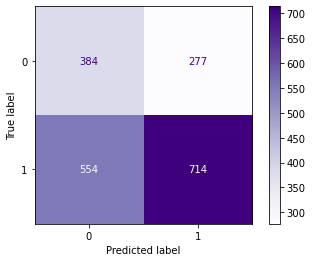

In [14]:
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples') 

In [15]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.5809
Accuracy: 0.5692
Precision: 0.7205
Recall or Sensitivity: 0.5631
F1 Score: 0.6321


In [16]:
model='xgb2bal'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()